<a href="https://colab.research.google.com/github/Fatemehkiasaveh/basicPythonExcercises/blob/main/workshop4_image_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


شبکه گفته شده را با شبکه زیر جایگزین کنید و دوباره فرآیند train را انجام دهید.) دقت مالک نیست (
) راهنمایی تمامی padding ها را same درنظر بگیرید و سایز کرنل الیه های کانولوشنی به ترتیب
).است( 3و3( واقع در 3 از منظور. بگیرید نظر در 3,2,3,2,3,2,1,2,2,2,1,3



Download the data

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.4M      0  0:00:26  0:00:26 --:--:-- 29.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  11.0M      0  0:00:01  0:00:01 --:--:-- 11.0M


In [1]:
import os
from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import backend as K

Prepare path of input image amd target segmentation mask

In [ ]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'
num_classes=3
img_size=(160,160)
batch_size =32

input_img_paths= sorted(
    os.path.join(input_dir,fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.jpg')
)
target_img_paths = sorted(
    os.path.join(target_dir,fname)
    for fname in os.listdir(target_dir)
      if fname.endswith('.png') and not fname.startswith('.')
)


In [ ]:
print(len(input_img_paths))
print(len(target_img_paths))

7390
7390


What does one input and the corresponding segmentation mask look like

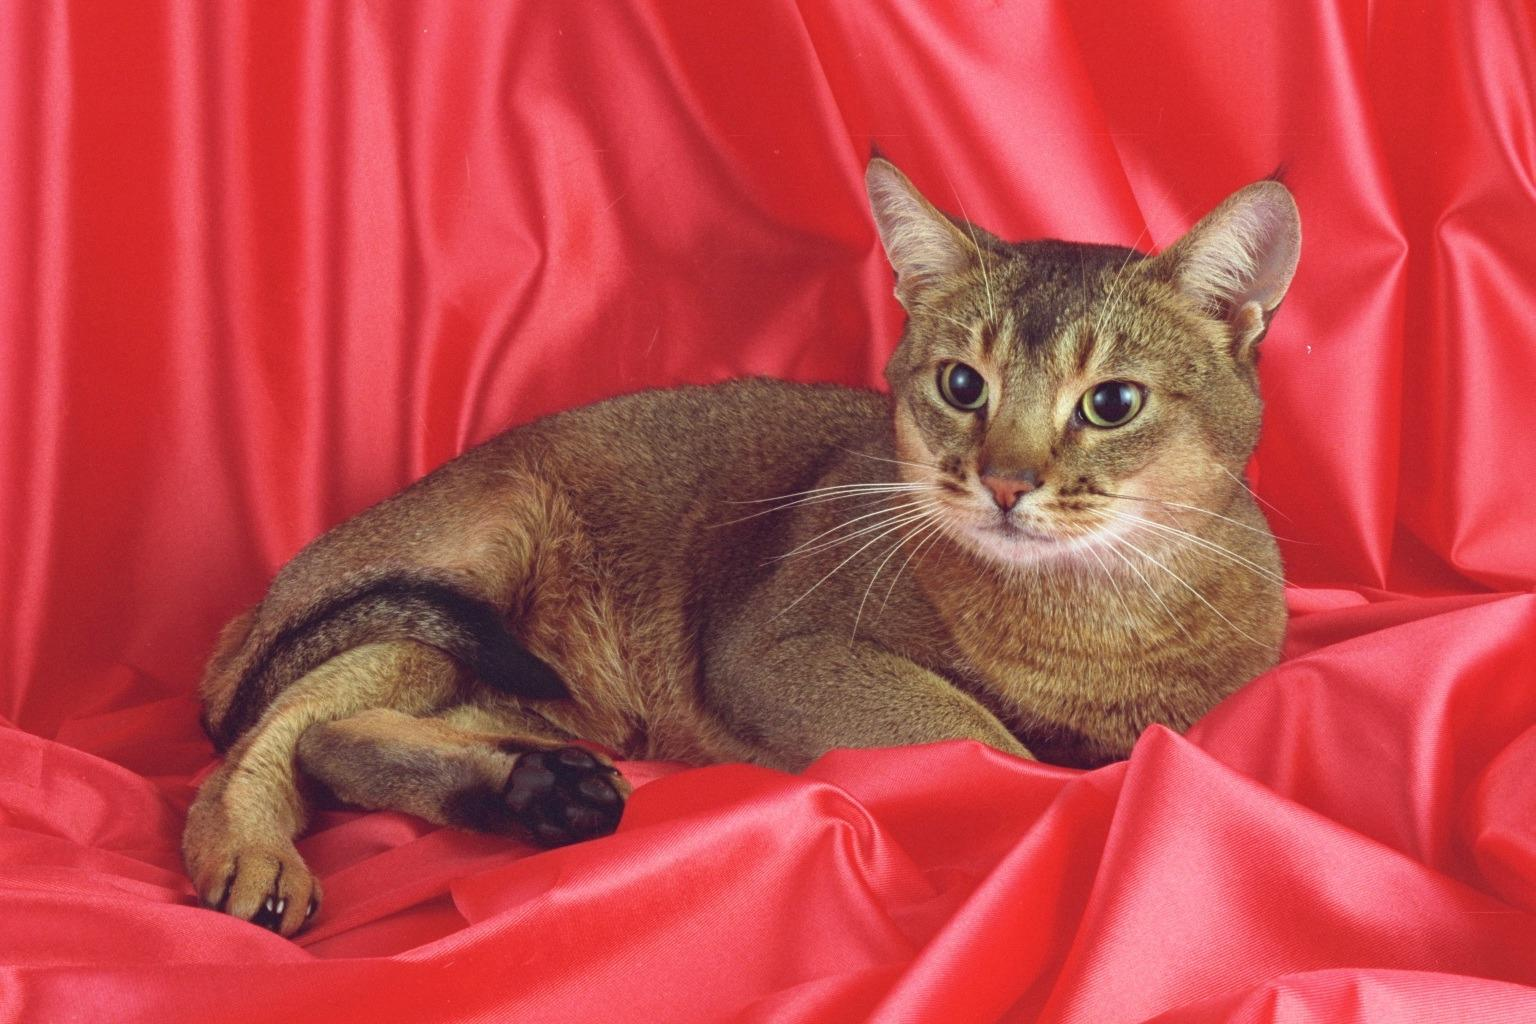

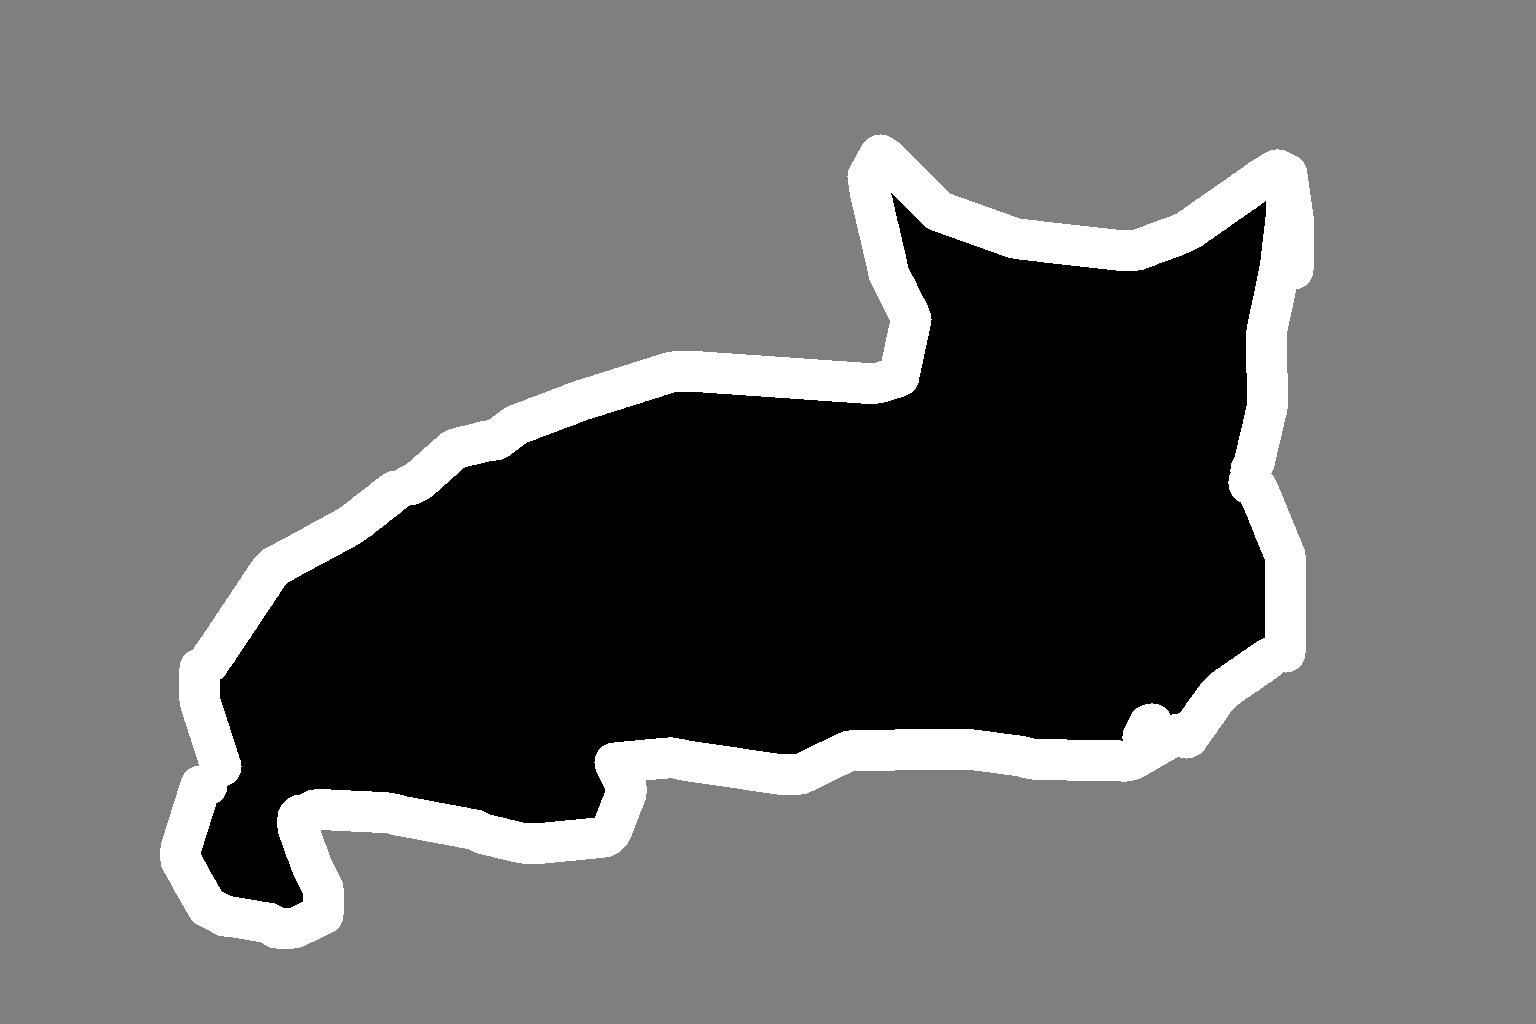

In [ ]:
display(Image(filename=input_img_paths[8]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[8]))
display(img)

Data loader

In [ ]:
class OxfordPets(keras.utils.Sequence):
  def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
    self.batch_size=batch_size
    self.img_size=img_size
    self.input_img_paths=input_img_paths
    self.target_img_paths=target_img_paths
  
  def __len__(self):
    return len(self.target_img_paths)//self.batch_size

  def __getitem__(self,idx):
    i = idx * self.batch_size
    batch_input_img_paths=self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths=self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size,)+self.img_size+(3,),dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path,target_size=img_size)
      x[j]=img
    y = np.zeros((self.batch_size,)+self.img_size+(1,),dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size,color_mode='grayscale')
      y[j]=np.expand_dims(img,2)
      y[j]-=1
    return x,y



Prepare UNET-Xception style model

In [ ]:
img_size =(160,160)
num_classes = 3
inputs=keras.Input(shape=img_size+(3,))
x = layers.Conv2D(8,3,1,'same')(inputs)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
previous_block_activation=x  
x = layers.Conv2D(8,1,2,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)

x = layers.Conv2D(16,2,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
second_block_acrivation = x
x = layers.Conv2D(16,2,2,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.Conv2D(32,2,1,'same')(x)
third_block_activation=x
x = layers.Conv2D(32,1,2,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.Conv2D(32,2,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.Conv2D(32,3,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)

x = layers.UpSampling2D(2)(x)
x = layers.concatenate([x,third_block_activation])
x = layers.Conv2D(32,2,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.UpSampling2D(2)(x)
x = layers.concatenate([x,second_block_acrivation])
x = layers.Conv2D(24,3,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.UpSampling2D(2)(x)
x = layers.concatenate([x,previous_block_activation])

x = layers.Conv2D(16,2,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.Conv2D(64,3,1,'same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Conv2D(num_classes,3,1,'same')(x)
model = keras.Model(inputs, outputs)
model.summary()


In [ ]:
from tensorflow.keras import layers
def get_model(img_size,num_classes):
  input = keras.Input(shape = img_size + (3,))
  #Downsampling Entry Block
  x = layers.Conv2D(8,3,1,'same')(inputs)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  previous_block_activation=x
  x = layers.Conv2D(8,1,2,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)

  x = layers.Conv2D(16,2,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  second_block_acrivation = x
  x = layers.Conv2D(16,2,2,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.Conv2D(32,2,1,'same')(x)
  third_block_activation=x
  x = layers.Conv2D(32,1,2,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.Conv2D(32,2,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.Conv2D(32,3,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)

  x = layers.UpSampling2D(2)(x)
  x = layers.concatenate([x,third_block_activation])
  x = layers.Conv2D(32,2,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.UpSampling2D(2)(x)
  x = layers.concatenate([x,second_block_acrivation])
  x = layers.Conv2D(24,3,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.UpSampling2D(2)(x)
  x = layers.concatenate([x,previous_block_activation])

  x = layers.Conv2D(16,2,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.Conv2D(64,3,1,'same')(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Conv2D(num_classes,3,1,'same')(x)
  model = keras.Model(inputs,outputs)
  return model
keras.backend.clear_session()

model = get_model(img_size,num_classes)
model.summary()

Set aside validation split

In [ ]:
import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(
    batch_size,img_size,train_input_img_paths,train_target_img_paths
)
val_gen = OxfordPets(batch_size,img_size,val_input_img_paths, val_target_img_paths)

Dice coefficient

In [ ]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
     
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=3)[...,:])
    y_pred_f = K.flatten(y_pred[...,:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    
    return 1 - dice_coef_9cat(y_true, y_pred)

Train the model

In [ ]:
model.compile(optimizer='rmsprop',loss=[dice_coef_9cat_loss], metrics=[dice_coef_9cat])

callbacks = [
             keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)
]
epochs = 15
model.fit(train_gen,epochs=epochs,validation_data=val_gen,callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 46s 221ms/step - loss: 0.3164 - dice_coef_9cat: 0.6836 - val_loss: -0.4658 - val_dice_coef_9cat: 1.4658
Epoch 2/15
199/199 [==============================] - 43s 217ms/step - loss: 0.8405 - dice_coef_9cat: 0.1595 - val_loss: -0.1516 - val_dice_coef_9cat: 1.1516
Epoch 3/15
199/199 [==============================] - 43s 216ms/step - loss: 0.3843 - dice_coef_9cat: 0.6157 - val_loss: 2.2363 - val_dice_coef_9cat: -1.2363
Epoch 4/15
199/199 [==============================] - 44s 219ms/step - loss: 0.4733 - dice_coef_9cat: 0.5267 - val_loss: 1.4784 - val_dice_coef_9cat: -0.4784
Epoch 5/15
199/199 [==============================] - 43s 215ms/step - loss: 0.2548 - dice_coef_9cat: 0.7452 - val_loss: -0.1695 - val_dice_coef_9cat: 1.1695
Epoch 6/15
199/199 [==============================] - 44s 219ms/step - loss: 0.5259 - dice_coef_9cat: 0.4741 - val_loss: 0.8296 - val_dice_coef_9cat: 0.1704
Epoch 7/15
199/199 [==============================] -

Visualize predictions

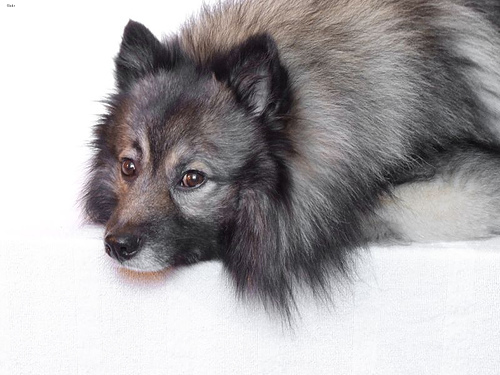

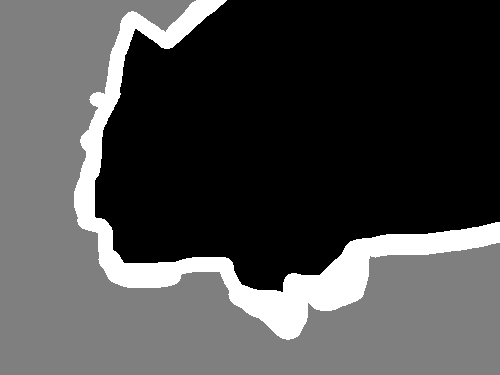

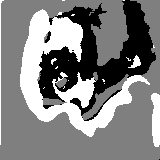

In [ ]:
val_gen = OxfordPets(batch_size,img_size,val_input_img_paths,val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
  mask = np.argmax(val_preds[i], axis = -1)
  mask = np.expand_dims(mask, axis = -1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

i = 2
display(Image(val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)